In [388]:
import numpy as np
import scipy.sparse as sps
import porepy as pp

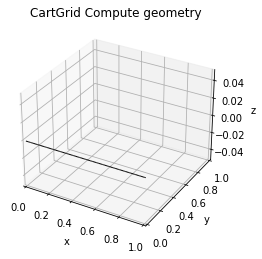

In [389]:
Nx=100
phys_dims=[1]
g=pp.CartGrid([Nx],phys_dims)
g.compute_geometry()
#pp.plot_grid(g,figsize=(15,12))
pp.plot_grid(g)

In [390]:
def add_transport_data(g):
    tol=1e-4
    
    b_faces = g.tags["domain_boundary_faces"].nonzero()[0]
    bc_val = np.zeros(g.num_faces)
    
    unity = np.ones(g.num_cells)
    empty = np.empty(0)
    if b_faces.size != 0:
        b_face_centers = g.face_centers[:, b_faces]
        b_inflow = b_face_centers[0, :] < tol
        b_outflow = b_face_centers[0, :] > 1-tol

        labels = np.array(["neu"] * b_faces.size)
        labels[np.logical_or(b_inflow, b_outflow)] = "dir"
        bc = pp.BoundaryCondition(g, b_faces, labels)

        bc_val[b_faces[b_inflow]] = 0

    else:
        bc = pp.BoundaryCondition(g) #, empty, empty)
    
    porosity=unity
    aperture=1
    
    specified_parameters = {
            "bc": bc,
            "bc_values": bc_val,
            "time_step": 0.001,
            "mass_weight": porosity * aperture,
            "darcy_flux":np.ones(Nx+1),
            "t_max": 1.0,
            }
    d=pp.initialize_default_data(g, {},'transport', specified_parameters)
    
    return g,d

In [391]:
g,d=add_transport_data(g)
kw_t = 'transport'

In [392]:
node_discretization = pp.Upwind(kw_t)
source_discretization = pp.ScalarSource(kw_t)
mass_discretization = pp.MassMatrix(kw_t)

In [393]:
d[pp.PARAMETERS]["transport"]["darcy_flux"]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [394]:
node_discretization.discretize(g,d)
source_discretization.discretize(g,d)
mass_discretization.discretize(g,d)

In [395]:
A_upwind,b_upwind=node_discretization.assemble_matrix_rhs(g,d)
_,b_source=source_discretization.assemble_matrix_rhs(g,d)
A_mass,b_mass=mass_discretization.assemble_matrix_rhs(g,d)

In [396]:
dt=d[pp.PARAMETERS]["transport"]["time_step"]
#lhs =1/dt*A_mass+A_upwind
lhs=1/dt*A_mass
rhs=b_upwind+b_source+b_mass
IEsolver = sps.linalg.factorized(lhs)

In [400]:
save_every = 1
n_steps = int(np.round(d[pp.PARAMETERS]["transport"]["t_max"] / d[pp.PARAMETERS]["transport"]["time_step"]))

# Initial condition
tracer = np.zeros(Nx)
stair=g.cell_centers[0,:]<0.3
stair_1=stair>0.2
tracer[np.logical_and(g.cell_centers[0,:]<0.3, g.cell_centers[0,:]>0.2)]=1.0

# Exporter
exporter = pp.Exporter(g, file_name="tracer",folder_name="solution")
tracer


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [401]:
for i in range(n_steps):
    
    if np.isclose(i % save_every, 0):
        # Export existing solution (final export is taken care of below)
        exporter.write_vtu({"tracer":tracer}, time_step=int(i // save_every))
    tracer = IEsolver((1/dt*A_mass-A_upwind) * tracer + rhs)
    print(tracer)

    
    

exporter.write_vtu({"tracer":tracer}, time_step=(n_steps // save_every))
time_steps = np.arange(
    0, d[pp.PARAMETERS]["transport"]["t_max"] + d[pp.PARAMETERS]["transport"]["time_step"], save_every * d[pp.PARAMETERS]["transport"]["time_step"]
)
exporter.write_pvd(time_steps)


[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.9 1.  1.  1.  1.  1.  1.  1.  1.  1.  0.1 0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.81 0.99 1.   1.   1.   1.   1.   1.
 1.   1.   0.19 0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.  ]
[0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 0.00e+00 0.00e+00 0.

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.95126654e-05 3.54151985e-04 2.12163273e-03 8.47147094e-03
 2.54043729e-02 6.11516102e-02 1.23378283e-01 2.15236704e-01
 3.32611353e-01 4.64476700e-01 5.96312534e-01 7.14533510e-01
 8.09358752e-01 8.74834272e-01 9.06925028e-01 9.02044537e-01
 8.57823467e-01 7.75732791e-01 6.63302309e-01 5.33778936e-01
 4.02954467e-01 2.84843928e-01 1.88422598e-01 1.16660995e-01
 6.76597700e-02 3.68005003e-02 1.87972624e-02 9.03022764e-03
 4.08626331e-03 1.74434454e-03 7.03481526e-04 2.68409359e-04
 9.70167340e-05 3.32618672e-05 1.08295736e-05 3.35213720e-06
 9.87476833e-07 2.77105428e-07 7.41421371e-08 1.89298953e-08
 4.61560942e-09 1.07551707e-09 2.39661916e-10 5.11019953e-11
 1.04322079e-11 2.040029

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.53662674e-08 4.93232978e-07 4.78201116e-06 3.08323675e-05
 1.48782592e-04 5.73403401e-04 1.83940248e-03 5.05463823e-03
 1.21549505e-02 2.60049424e-02 5.01654584e-02 8.82361466e-02
 1.42871017e-01 2.14763176e-01 3.01974480e-01 3.99876131e-01
 5.01716153e-01 5.99585252e-01 6.85457568e-01 7.52075114e-01
 7.93629729e-01 8.06322662e-01 7.88859224e-01 7.42802386e-01
 6.72594318e-01 5.85073416e-01 4.88478324e-01 3.91145142e-01
 3.00241601e-01 2.20868064e-01 1.55708011e-01 1.05214511e-01
 6.81656276e-02 4.23614827e-02 2.52651699e-02 1.44702223e-02
 7.96350810e-03 4.21400111e-03 2.14553375e-03 1.05175955e-03
 4.96735423e-04 2.26174373e-04 9.93451167e-05 4.21213107e-05
 1.72491675e-05 6.826449

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.58939641e-11 4.32669023e-10 5.87389895e-09 5.30312250e-08
 3.58243919e-07 1.93178492e-06 8.66304363e-06 3.32374802e-05
 1.11397841e-04 3.31404783e-04 8.86311164e-04 2.15306676e-03
 4.79213636e-03 9.84467731e-03 1.87866510e-02 3.34901584e-02
 5.60516417e-02 8.84780946e-02 1.32268916e-01 1.87975446e-01
 2.54843088e-01 3.30630673e-01 4.11661716e-01 4.93108670e-01
 5.69464550e-01 6.35129290e-01 6.85031299e-01 7.15208860e-01
 7.23281843e-01 7.08749667e-01 6.73062796e-01 6.19440533e-01
 5.52449498e-01 4.77406296e-01 3.99708257e-01 3.24212164e-01
 2.54765458e-01 1.93952795e-01 1.43067467e-01 1.02269155e-01
 7.08596496e-02 4.76008236e-02 3.10111164e-02 1.95995800e-02
 1.20212951e-02 7.157918

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.79949328e-16 1.46069408e-14 2.80177449e-13 3.57521894e-12
 3.41458817e-11 2.60368786e-10 1.65122072e-09 8.95871260e-09
 4.24513837e-08 1.78489517e-07 6.74272936e-07 2.31186058e-06
 7.25494899e-06 2.09857476e-05 5.62934932e-05 1.40770391e-04
 3.29669235e-04 7.25982029e-04 1.50880306e-03 2.96907984e-03
 5.54864671e-03 9.87441579e-03 1.67758389e-02 2.72717958e-02
 4.25144599e-02 6.36833393e-02 9.18322477e-02 1.27703658e-01
 1.71535869e-01 2.22895591e-01 2.80569607e-01 3.42543285e-01
 4.06081820e-01 4.67914540e-01 5.24506149e-01 5.72384485e-01
 6.08484242e-01 6.30461878e-01 6.36939240e-01 6.27642284e-01
 6.03415724e-01 5.66112400e-01 5.18374739e-01 4.63341469e-01
 4.04322610e-01 3.444878

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.51475291e-21 7.80939277e-20 2.00959089e-18 3.44158177e-17
 4.41293999e-16 4.51911755e-15 3.85009805e-14 2.80689178e-13
 1.78763796e-12 1.01037627e-11 5.13147811e-11 2.36556227e-10
 9.98104393e-10 3.88157306e-09 1.39965978e-08 4.70390091e-08
 1.48001911e-07 4.37692708e-07 1.22092994e-06 3.22253172e-06
 8.07083497e-06 1.92295378e-05 4.36881571e-05 9.48490993e-05
 1.97166636e-04 3.93147894e-04 7.53244151e-04 1.38885819e-03
 2.46810193e-03 4.23304101e-03 7.01603241e-03 1.12515828e-02
 1.74792232e-02 2.63325652e-02 3.85103076e-02 5.47267043e-02
 7.56418548e-02 1.01775833e-01 1.33414551e-01 1.70518597e-01
 2.12648343e-01 2.58918701e-01 3.07994817e-01 3.58135669e-01
 4.07286628e-01 4.532153

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.02269318e-26 6.55659964e-25 2.09868005e-23 4.47187746e-22
 7.13617480e-21 9.09714793e-20 9.65032154e-19 8.76220833e-18
 6.95152060e-17 4.89535931e-16 3.09833132e-15 1.78024508e-14
 9.36375855e-14 4.54016516e-13 2.04139989e-12 8.55555089e-12
 3.35716996e-11 1.23826036e-10 4.30802169e-10 1.41815208e-09
 4.42956798e-09 1.31610736e-08 3.72829252e-08 1.00908518e-07
 2.61444637e-07 6.49582622e-07 1.55025189e-06 3.55911762e-06
 7.87168836e-06 1.67938963e-05 3.46042266e-05 6.89452364e-05
 1.32969070e-04 2.48493673e-04 4.50423666e-04 7.92627088e-04
 1.35531067e-03 2.25368260e-03 3.64732951e-03 5.74928578e-03
 8.83329253e-03 1.32373195e-02 1.93611671e-02 2.76560003e-02
 3.86040897e-02 5.268790

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 8.52440174e-32 6.51643156e-30 2.48757829e-28 6.32273657e-27
 1.20378560e-25 1.83121590e-24 2.31850005e-23 2.51297652e-22
 2.38034907e-21 2.00173059e-20 1.51314651e-19 1.03856641e-18
 6.52638282e-18 3.78116268e-17 2.03176488e-16 1.01775154e-15
 4.77384762e-15 2.10502638e-14 8.75625312e-14 3.44665497e-13
 1.28737631e-12 4.57439398e-12 1.54979148e-11 5.01682063e-11
 1.55463095e-10 4.61987883e-10 1.31868389e-09 3.62082787e-09
 9.57714426e-09 2.44336123e-08 6.01988598e-08 1.43393628e-07
 3.30578329e-07 7.38340188e-07 1.59913868e-06 3.36163514e-06
 6.86462141e-06 1.36279980e-05 2.63225263e-05 4.95014323e-05
 9.06990220e-05 1.62019928e-04 2.82350770e-04 4.80315042e-04
 7.98051701e-04 1.295818

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.20328890e-36 1.06156821e-34 4.67746620e-33 1.37245438e-31
 3.01691639e-30 5.29952055e-29 7.74903826e-28 9.70136121e-27
 1.06156692e-25 1.03141339e-24 9.00918223e-24 7.14614131e-23
 5.19035734e-22 3.47608659e-21 2.15938902e-20 1.25066680e-19
 6.78358680e-19 3.45928383e-18 1.66429289e-17 7.57765879e-17
 3.27423155e-16 1.34599256e-15 5.27622987e-15 1.97630453e-14
 7.08693032e-14 2.43721982e-13 8.05123628e-13 2.55863636e-12
 7.83308650e-12 2.31309919e-11 6.59650408e-11 1.81877631e-10
 4.85341970e-10 1.25472683e-09 3.14548719e-09 7.65324898e-09
 1.80877215e-08 4.15569601e-08 9.28859024e-08 2.02120348e-07
 4.28467260e-07 8.85425494e-07 1.78476003e-06 3.51120262e-06
 6.74565346e-06 1.266245

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.55122627e-41 3.52360562e-39 1.74633963e-37 5.76423897e-36
 1.42554295e-34 2.81755983e-33 4.63607055e-32 6.53200101e-31
 8.04484107e-30 8.79840694e-29 8.65171011e-28 7.72639714e-27
 6.31879750e-26 4.76542641e-25 3.33393878e-24 2.17482695e-23
 1.32873640e-22 7.63310383e-22 4.13731443e-21 2.12243758e-20
 1.03337198e-19 4.78710097e-19 2.11480508e-18 8.92791541e-18
 3.60857290e-17 1.39888920e-16 5.20944180e-16 1.86639832e-15
 6.44200898e-15 2.14486034e-14 6.89694579e-14 2.14427433e-13
 6.45245148e-13 1.88112415e-12 5.31815199e-12 1.45926410e-11
 3.88951283e-11 1.00782168e-10 2.54050874e-10 6.23463777e-10
 1.49054566e-09 3.47375308e-09 7.89651400e-09 1.75188633e-08
 3.79533936e-08 8.033397

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.43767013e-45 1.57983974e-43 8.67236347e-42 3.17082110e-40
 8.68697995e-39 1.90220764e-37 3.46791409e-36 5.41420935e-35
 7.38947323e-34 8.95661008e-33 9.76160604e-32 9.66299564e-31
 8.76032100e-30 7.32441906e-29 5.68132301e-28 4.10933167e-27
 2.78402858e-26 1.77360807e-25 1.06617724e-24 6.06641938e-24
 3.27621566e-23 1.68359551e-22 8.25116626e-22 3.86460103e-21
 1.73312053e-20 7.45493093e-20 3.08067630e-19 1.22484321e-18
 4.69185527e-18 1.73378132e-17 6.18796783e-17 2.13545483e-16
 7.13305162e-16 2.30849673e-15 7.24524567e-15 2.20711479e-14
 6.53132962e-14 1.87897390e-13 5.25898790e-13 1.43301032e-12
 3.80408757e-12 9.84419198e-12 2.48484553e-11 6.12149939e-11
 1.47262939e-10 3.461258

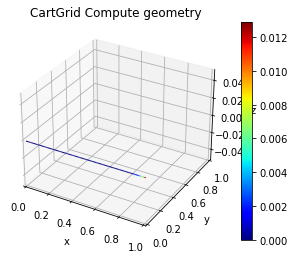

In [402]:
pp.plot_grid(g,tracer)